# Kullback-Leibler Divergence

## Approximate Inference
We want to approximate $p(X) = \frac{1}{Z}\tilde p(X)$ with simpler distribution $q(X;\phi)$ and to adjust $\phi$ so that distributions are close, i.e. 
$$\sum_x f(x)p(x)\approx \sum_x f(x)q(x;\phi), E_{x\sim p(x)}[f(x)]\approx E_{x\sim q(x;\phi)}[f(x)]$$

However, to define how close the $\approx$ is, we need a measurement. We cannot use distance measurement because of the different scales of parameters. 

## KL Divergence
$$D_{KL}(q\parallel p) E_{x\sim q(x)}\log(\frac{q(x)}{p(x)}) = \sum_x q(x)\log(\frac{q(x)}{p(x)})$$

Note that 
 - $D_{KL}(q\parallel p) \geq 0$
 - $D_{KL}(q \parallel p) = 0 \Leftrightarrow q = p$
 - $D_{KL}(q\parallel p) \neq D_{KL}(p\parallel q)$ generally, so that KL is not a norm

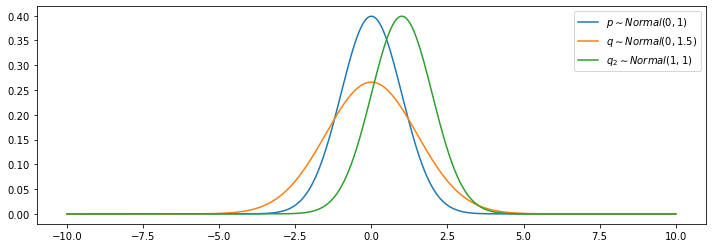

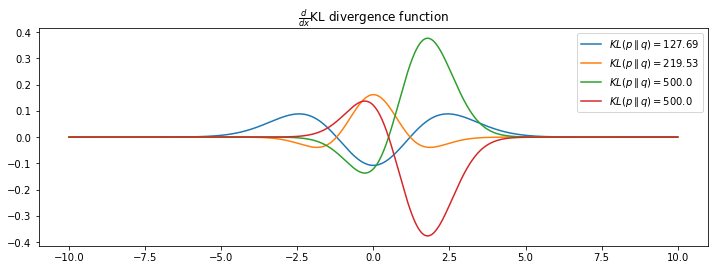

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
def kl_divergence(p, q):
    return round(np.sum(np.where(p != 0, p * np.log(p / q), 0)), 2)

plt.figure(figsize=(12, 4))
x = np.arange(-10, 10, 0.001)
p = stats.norm.pdf(x)
q = stats.norm.pdf(x, 0, 1.5)
q2 = stats.norm.pdf(x, 1)
plt.plot(x, p, label=r"$p\sim Normal(0, 1)$")
plt.plot(x, q, label=r"$q\sim Normal(0, 1.5)$")
plt.plot(x, q2, label=r"$q_2 \sim Normal(1, 1)$")
plt.legend();
plt.show()

plt.figure(figsize=(12, 4))
plt.title(r"$\frac{d}{dx}$KL divergence function")
plt.plot(x, np.log(q/p) * q, label=rf"$KL(p \parallel q) = {kl_divergence(p, q)}$")
plt.plot(x, np.log(p/q) * p, label=rf"$KL(p \parallel q) = {kl_divergence(q, p)}$")
plt.plot(x, np.log(q2/p) * q2, label=rf"$KL(p \parallel q) = {kl_divergence(p, q2)}$")
plt.plot(x, np.log(p/q2) * q2, label=rf"$KL(p \parallel q) = {kl_divergence(q2, p)}$")
plt.legend();

| | Name | $p\sim q$ | large $p$ small $q$ | large $q$ small $p$ | penalization |
| --- | --- | --- | --- | --- | --- |
|$D_{KL}(q\parallel p)$|Reverse-KL (Information Projection)| small | small | large | penalizes $q$ having mass where $p$ has none | 
|$D_{KL}(p\parallel q)$|Forward-KL (Moment Projection)| small | large | small | penalizes $q$ missing mass where $p$ has some |

# Stochastic Variational Inference
## Posterior Inference in Latent Variable Models 
Consider the probabilistic model $p(x, z)$ where $x_{1:T}$ are the observations and $z_{1:N}$ are the unobserved latent variables. 

The conditional distribution of the unobserved variables given the observed variables (the posterior inference) is 
$$p(z|x) = \frac{p(x|z)}{p(x)} = \frac{p(x|z)p(z)}{\int p(x,z)dz}$$
which we will denote as $p_\theta(z|x)$
Note that the integral is intractable. 

## Approximating Posterior Inference with Variational Methods
Because the intractable computation in exact inference of the posterior distribution, we need to approximate the inference.  

### General Settings
 - Introduce a variational family $q_\phi(z)$ with parameter $\phi$. 
 - Encode some notion of distance between $p(z|x)$ and $q_\phi(x)$, we often use KL divergence.
 - Minimize the distance, i.e. $q_\phi \approx p \Rightarrow D_{KL}(q_\phi\parallel p) = 0$. 

### Evidence lower bound (ELBO)

Note that KL divergence $KL(q\parallel p) = E_{x\sim q}(\log(q_\phi) - \log(p))$ is an intractable integral, hence we are unable to compute. 

\begin{align*}
D_{KL}(q_\phi(z|x)\parallel p(z|x)) &= E_{z\sim q_\phi}(\log \frac{q_\phi(z|x)}{p(z|x)}) \\
&= E_{z\sim q_\phi}\bigg[\log(q_\phi(z|x) \frac{p(x)}{p(z, x)})\bigg]\\
&= E_{z\sim q_\phi}\log\frac{q_\phi(z|x)}{p(z, x)} + E_{z\sim q_\phi}(\log p(x)) \\
&= -\mathcal L(\phi; x) + \log(p(x))
\end{align*}
where $\mathcal L(\phi; x)$ is the __ELBO__. 

Note that $D_{KL}(q_\phi(z|x)\parallel p(z|x))\geq 0$ (as of KL divergence property), and 
$$\mathcal L(\phi; x) + D_{KL}(q_\phi(z|x)\parallel p(z|x)) = \log p(x)$$
Therefore, max ELBO is the same as min KL divergence

And note that 
$$ELBO = \mathcal L(\phi) = -E_{z\sim q} \log\frac{q_\phi(z|x)}{p(x, z)} = E_{z\sim q_\phi}[\log p(x, z) - \log q_\phi(z|x)]$$
which is the ELBO

Using simple Monte Carlo sampling, we can easily approximate this by drawing $z$ from $q_\phi$ and then compute $mean(\log p(x, z) - \log q_\phi(x|z))$

#### Intuitions behind ELBO
Note that 
\begin{align*}
ELBO &= E_{z\sim q_\phi}[\log p(x, z) - \log q_\phi(z|x)] &(*)\\
&= E_{z\sim q_\phi} [\log p(x|z) + \log p(z)] \mathbb H[q_\phi(z|x)] &(**)\\
&= E_{z\sim q_\phi}[\log p(x|z)] - D_{KL}(q_\phi(z|x)\parallel p(z)) &(***)
\end{align*}
$(***)$

$E[\log p(x|z)]$ can be thought of as a reconstruction likelihood, i.e. how probable is $x|z$, encourages the model to choose the distribution which best reconstructs the data. 

$D_{KL}(q_\phi \parallel p)$ can be thought as the regularization, by enforcing the idea that our parameterization shouldn't move too far from the true distribution. 

### Path-wise Gradient 
Now, consider the computation graph, note that if we have $z$ draw from some distribution, then we are unable to backprop to $\phi$, therefore, we need the reparameterization tricks to move randomness on $z$ to some other nodes that is not on the computational path. 

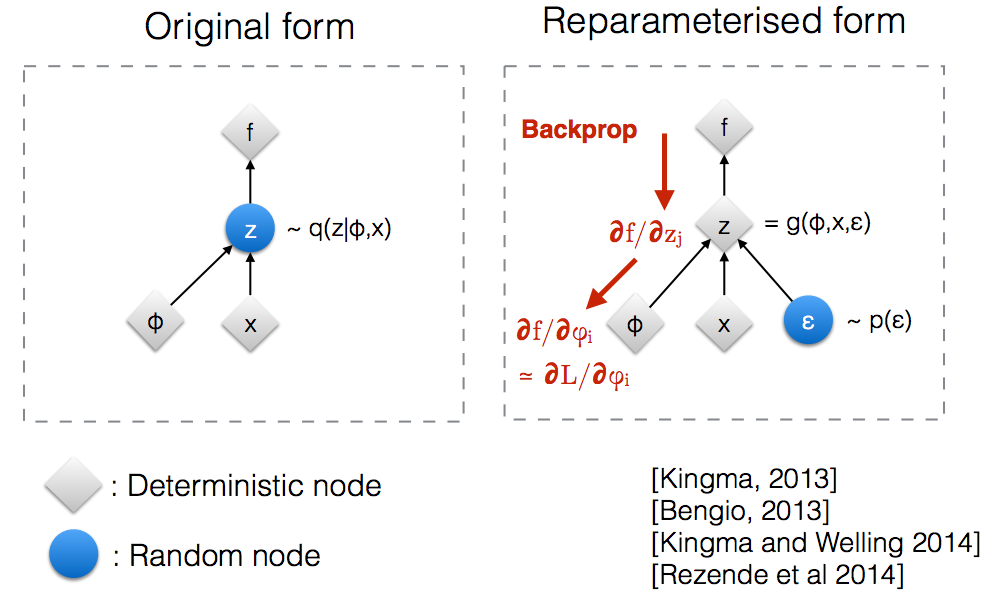

In [59]:
from PIL import Image
display(Image.open("assets/reparameterization.png"))

One simple example is that if $q_\phi(z) \sim N(z; \mu, \phi)$ then we can have $\epsilon \sim N(0, 1)\Rightarrow z = \sigma\epsilon + \mu$